In [16]:
#imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Combine csv data of all station into one big dataframe

In [18]:
list_of_csv = ["./../KW34/PFExport_Station_1_2025-08-20T12_12_02_Results.csv",
               "./../KW34/PFExport_Station_2_2025-08-20T11_05_10_Results.csv",
               "./../KW34/PFExport_Station_3_2025-08-20T11_05_23_Results.csv",
               "./../KW34/PFExport_Station_4_2025-08-20T12_05_57_Results.csv",
               "./../KW34/PFExport_Station_5_2025-08-20T12_05_37_Results.csv"]

list_of_df = []
#read all csv and append to new df list
for file in list_of_csv:
    df = pd.read_csv(file, sep = ";", usecols = [1, 6, 10, 11, 12],skiprows = 2, header = None)
    list_of_df.append(df)
#concat all dfs with all stations
df = pd.concat(list_of_df, ignore_index=True)

#split cols with date and time and drop useless col with date+time
df[["Datum", "Uhrzeit"]] = df[6].str.split(" ", expand = True)
df = df.drop(6, axis = 1)

#evaluate a minimum start date to drop older screw data
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df[df["Datum"] >= pd.to_datetime("01.07.2025", format="%d.%m.%Y")]

#set column headers
header = ["Station", "Status", "Statusinfo", "Bauteil", "Datum", "Uhrzeit"]
df.columns = header

df.tail()

,Station,Status,Statusinfo,Bauteil,Datum,Uhrzeit
42643,Station 5,Verschraubung IO,Verschraubung IO,5.FAT L - 19,2025-07-01,11:40:19
42644,Station 5,Verschraubung IO,Verschraubung IO,4.FAT L - 10,2025-07-01,11:40:16
42645,Station 5,Verschraubung IO,Verschraubung IO,3.FAT L - 03,2025-07-01,11:40:13
42646,Station 5,Verschraubung IO,Verschraubung IO,2.FAT L - 11,2025-07-01,11:40:09
42647,Station 5,Verschraubung IO,Verschraubung IO,1.FAT L - 12,2025-07-01,11:40:05


# Filterung zur Analyse und Visualisierung

In [206]:
#Filterung nach Datum
start_date = pd.to_datetime("2025-07-28")
end_date = pd.to_datetime("2025-08-03")
df_filtered = df[(df["Datum"] >= start_date) & (df["Datum"] <= end_date)]
df_filtered.tail()

,Station,Status,Statusinfo,Bauteil,Datum,Uhrzeit
40781,Station 5,Verschraubung IO,Verschraubung IO,28.FOT-V R - 04,2025-07-29,11:02:10
40782,Station 5,Verschraubung IO,Verschraubung IO,11.FOT-V L - 10,2025-07-29,10:55:43
40783,Station 5,Verschraubung IO,Verschraubung IO,10.FOT-V L - 03,2025-07-29,10:55:40
40784,Station 5,Verschraubung IO,Verschraubung IO,9.FOT-V L - 08,2025-07-29,10:55:36
40785,Station 5,Verschraubung IO,Verschraubung IO,24.FAT R - 07,2025-07-29,10:55:33


## Detailed Dataframe (IOvsNIO)

In [208]:
df_grouped_detailed = df_filtered.groupby([df_filtered["Datum"].dt.date, "Station", "Bauteil", "Status"]).size().unstack(fill_value=0)

df_grouped_detailed = df_grouped_detailed.loc[df_grouped_detailed.index.get_level_values("Bauteil").str.contains("FAT", case=False, na=False)]

df_grouped_detailed["Fehler in %"] = (df_grouped_detailed["Verschraubung NIO"] / 
                                     (df_grouped_detailed["Verschraubung IO"] + 
                                      df_grouped_detailed["Verschraubung NIO"]) * 100).round(1)
#sort for most NIO
df_grouped_detailed = df_grouped_detailed.reset_index()
if "Verschraubung NIO" in df_grouped_detailed.columns:
    df_grouped_detailed = df_grouped_detailed.sort_values(by=["Datum", "Station", "Fehler in %"], ascending=[True, True, False])
df_grouped_detailed = df_grouped_detailed.set_index(["Datum", "Station", "Bauteil"])
df_grouped_detailed.tail()
#df_grouped_detailed.to_excel("df_grouped_detailed.xlsx")

Status                              Verschraubung IO  Verschraubung NIO  \
Datum      Station   Bauteil                                              
2025-08-01 Station 5 23.FAT R - 07                 1                  0   
                     24.FAT R - 33                 1                  0   
                     25.FAT R - 32                 1                  0   
                     26.FAT R - 30                 1                  0   
                     27.FAT R - 15                 1                  0   

Status                              Fehler in %  
Datum      Station   Bauteil                     
2025-08-01 Station 5 23.FAT R - 07          0.0  
                     24.FAT R - 33          0.0  
                     25.FAT R - 32          0.0  
                     26.FAT R - 30          0.0  
                     27.FAT R - 15          0.0

### Detailed Dataframe (IOvsNIO) weekly

In [92]:
df_grouped_detailed = df_filtered.groupby([ "Station", "Bauteil", "Status"]).size().unstack(fill_value=0)

df_grouped_detailed = df_grouped_detailed.loc[df_grouped_detailed.index.get_level_values("Bauteil").str.contains("FAT", case=False, na=False)]

df_grouped_detailed["Fehler in %"] = (df_grouped_detailed["Verschraubung NIO"] / 
                                     (df_grouped_detailed["Verschraubung IO"] + 
                                      df_grouped_detailed["Verschraubung NIO"]) * 100).round(1)
#sort for most NIO
df_grouped_detailed = df_grouped_detailed.reset_index()
if "Verschraubung NIO" in df_grouped_detailed.columns:
    df_grouped_detailed = df_grouped_detailed.sort_values(by=["Station", "Fehler in %"], ascending=[True, False])
df_grouped_detailed = df_grouped_detailed.set_index(["Station", "Bauteil"])
df_grouped_detailed.tail()
#df_grouped_detailed.to_excel("df_grouped_detailed.xlsx")

### Paretodiagram without left & right filter

C:\Temp\ipykernel_2104\1492763772.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')


Text(0.5, 1.0, 'Pareto-Diagramm der Fehlverschraubungen am 2025-07-31')

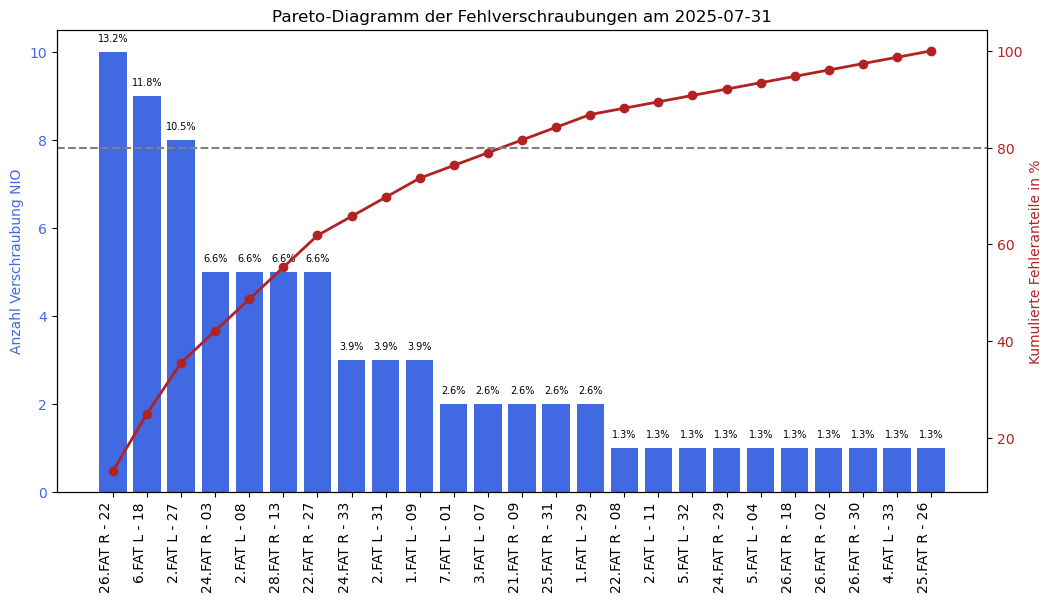

In [140]:
df_pareto = df_grouped_detailed
df_pareto = df_pareto.sort_values('Verschraubung NIO', ascending=False)
total_nio = df_pareto['Verschraubung NIO'].sum()
df_pareto['Kumulierter Anteil in %'] = df_pareto['Verschraubung NIO'].cumsum() / total_nio * 100
df_pareto = df_pareto.reset_index()
df_pareto = df_pareto.drop(["Datum", "Station", "Fehler in %"], axis = 1)
df_pareto = df_pareto[df_pareto["Verschraubung NIO"] != 0]
df_pareto['Fehleranteil in %'] = df_pareto['Verschraubung NIO'] / total_nio * 100

#PLOT
fig, ax1 = plt.subplots(figsize=(12, 6))

bars = ax1.bar(df_pareto['Bauteil'], df_pareto['Verschraubung NIO'], color='royalblue')
ax1.set_ylabel('Anzahl Verschraubung NIO', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')

for bar, percent in zip(bars, df_pareto['Fehleranteil in %']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{percent:.1f}%', ha='center', va='bottom', fontsize=7)

ax2 = ax1.twinx()
ax2.plot(df_pareto['Bauteil'], df_pareto['Kumulierter Anteil in %'], color='firebrick', marker='o', linewidth=2)
ax2.set_ylabel('Kumulierte Fehleranteile in %', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.axhline(80, color='gray', linestyle='--', label='80 % Schwelle')

plt.title(f'Pareto-Diagramm der Fehlverschraubungen am {start_date.date()}')
#ax1.legend(['Anzahl NIO'], loc='lower right')
#ax2.legend(loc='right')

### Paretodiagram with left & right filter

Text(0.5, 1.0, 'Pareto-Diagramm der Fehlverschraubungen am 2025-07-31')

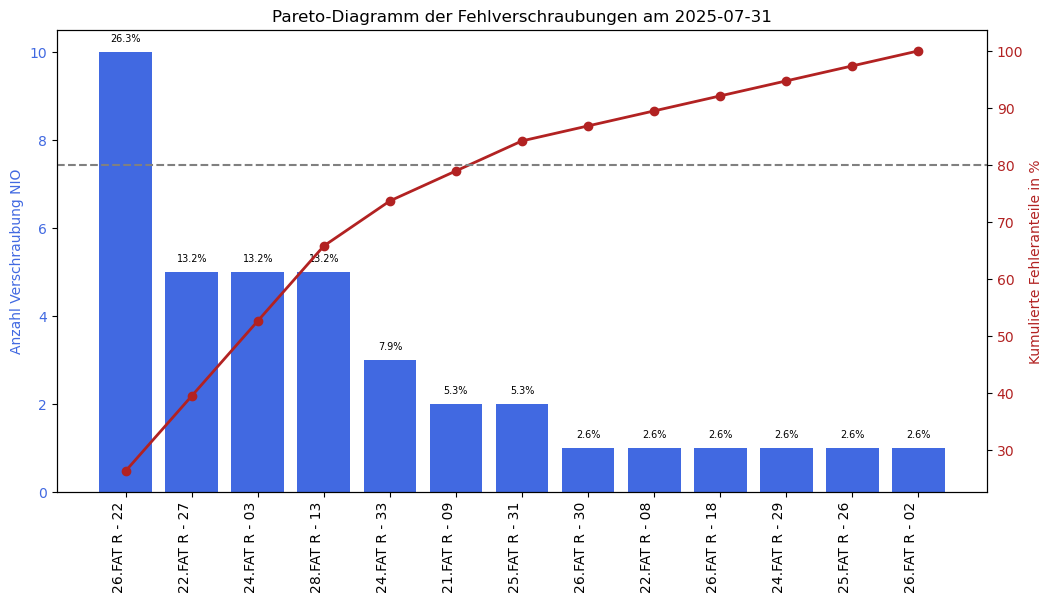

In [142]:
df_pareto = df_grouped_detailed
df_pareto = df_pareto[df_pareto.index.get_level_values('Bauteil').str.contains('FAT R')]

df_pareto = df_pareto.sort_values('Verschraubung NIO', ascending=False)
total_nio = df_pareto['Verschraubung NIO'].sum()
df_pareto['Kumulierter Anteil in %'] = df_pareto['Verschraubung NIO'].cumsum() / total_nio * 100
df_pareto = df_pareto.reset_index()
df_pareto = df_pareto.drop(["Datum", "Station", "Fehler in %"], axis = 1)
df_pareto = df_pareto[df_pareto["Verschraubung NIO"] != 0]
df_pareto['Fehleranteil in %'] = df_pareto['Verschraubung NIO'] / total_nio * 100

#PLOT
fig, ax1 = plt.subplots(figsize=(12, 6))

bars = ax1.bar(df_pareto['Bauteil'], df_pareto['Verschraubung NIO'], color='royalblue')
ax1.set_ylabel('Anzahl Verschraubung NIO', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
#ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')
ax1.set_xticks(range(len(df_pareto['Bauteil'])))
ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')

for bar, percent in zip(bars, df_pareto['Fehleranteil in %']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{percent:.1f}%', ha='center', va='bottom', fontsize=7)

ax2 = ax1.twinx()
ax2.plot(df_pareto['Bauteil'], df_pareto['Kumulierter Anteil in %'], color='firebrick', marker='o', linewidth=2)
ax2.set_ylabel('Kumulierte Fehleranteile in %', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.axhline(80, color='gray', linestyle='--', label='80 % Schwelle')

plt.title(f'Pareto-Diagramm der Fehlverschraubungen am {start_date.date()}')
#ax1.legend(['Anzahl NIO'], loc='lower right')
#ax2.legend(loc='right')

### Paretodiagram with left and right filter and with KW

C:\Temp\ipykernel_2104\4026022329.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')


Text(0.5, 1.0, 'HIER MUSS NOCH EINE GENAUE BESCHREIBUNG REIN')

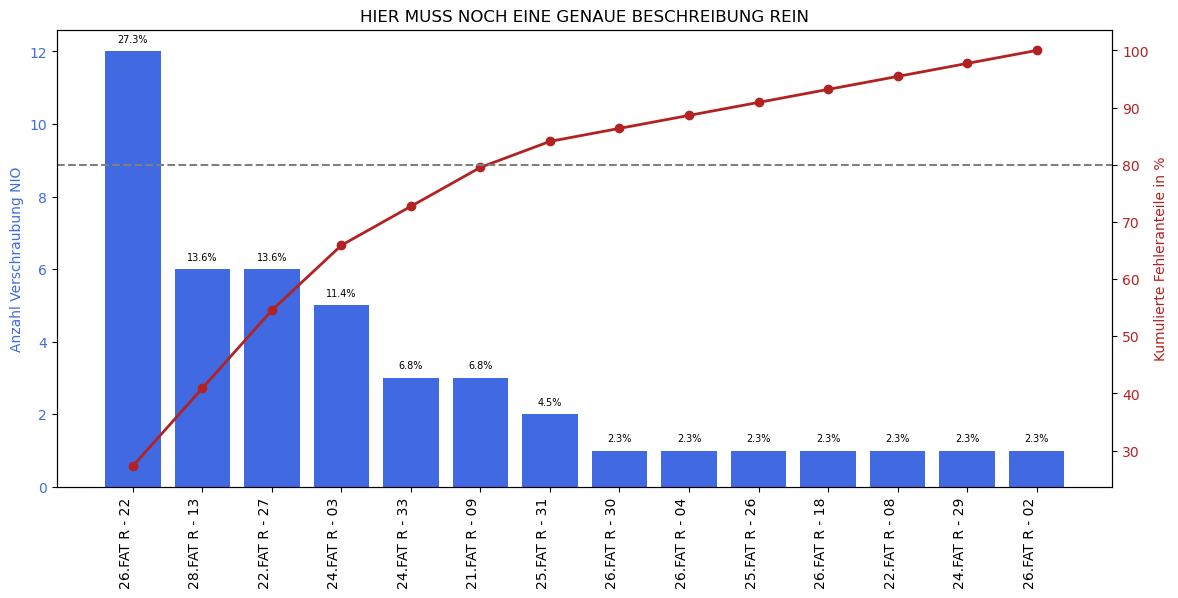

In [254]:
df_pareto = df_grouped_detailed
df_pareto = df_pareto[df_pareto.index.get_level_values('Bauteil').str.contains('FAT R')]

df_pareto = df_pareto.reset_index(level = ['Bauteil'])
df_pareto = df_pareto[['Bauteil', 'Verschraubung IO', 'Verschraubung NIO']]
df_pareto = df_pareto.reset_index()
df_pareto = df_pareto.drop(['Datum', 'Station'], axis = 1)
df_pareto = df_pareto.groupby('Bauteil', as_index=False).sum()
df_pareto = df_pareto.sort_values('Verschraubung NIO', ascending=False)
total_nio = df_pareto['Verschraubung NIO'].sum()
df_pareto['Kumulierter Anteil in %'] = df_pareto['Verschraubung NIO'].cumsum() / total_nio * 100
df_pareto = df_pareto[df_pareto["Verschraubung NIO"] != 0]
df_pareto['Fehleranteil in %'] = df_pareto['Verschraubung NIO'] / total_nio * 100

#PLOT

fig, ax1 = plt.subplots(figsize=(12, 6))

bars = ax1.bar(df_pareto['Bauteil'], df_pareto['Verschraubung NIO'], color='royalblue')
ax1.set_ylabel('Anzahl Verschraubung NIO', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.set_xticklabels(df_pareto['Bauteil'], rotation=90, ha='right')
ax1.set_xticks(range(len(df_pareto['Bauteil'])))

for bar, percent in zip(bars, df_pareto['Fehleranteil in %']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{percent:.1f}%', ha='center', va='bottom', fontsize=7)

ax2 = ax1.twinx()
ax2.plot(df_pareto['Bauteil'], df_pareto['Kumulierter Anteil in %'], color='firebrick', marker='o', linewidth=2)
ax2.set_ylabel('Kumulierte Fehleranteile in %', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.axhline(80, color='gray', linestyle='--', label='80 % Schwelle')
plt.tight_layout(pad = 1.5)
plt.title(f'HIER MUSS NOCH EINE GENAUE BESCHREIBUNG REIN')



### Super Detailed Dataframe (explicit failures shown)

In [ ]:
#groupby aggregation
df_grouped_super_detailed = df_filtered.groupby([df_filtered["Datum"].dt.date,"Station", "Bauteil", "Statusinfo"]).size().unstack()

#delete cols without entry
df_grouped_super_detailed = df_grouped_super_detailed.loc[:, (df_grouped_super_detailed != 0).any(axis=0)]

#fill up int values 
df_grouped_super_detailed = df_grouped_super_detailed.fillna(0).astype(int)

cols = df_grouped_super_detailed.columns.tolist()
if "Verschraubung IO" in cols: 
    cols = ["Verschraubung IO"] + [col for col in cols if col != "Verschraubung IO"] 
    df_grouped_super_detailed = df_grouped_super_detailed[cols]


df_grouped_super_detailed = df_grouped_super_detailed.loc[df_grouped_super_detailed.index.get_level_values("Bauteil").str.contains("FAT", case=False, na=False)]

#df_grouped_super_detailed.head()

#df_grouped_super_detailed.to_excel("df_grouped_super_detailed.xlsx")

### Super Detailed Dataframe weekly base

In [ ]:
df_grouped_super_detailed_weekly = df_filtered.groupby(["Station", "Bauteil", "Statusinfo"]).size().unstack()
#delete cols without entry
df_grouped_super_detailed_weekly = df_grouped_super_detailed_weekly.loc[:, (df_grouped_super_detailed_weekly != 0).any(axis=0)]

#fill up int values 
df_grouped_super_detailed_weekly = df_grouped_super_detailed_weekly.fillna(0).astype(int)

cols = df_grouped_super_detailed_weekly.columns.tolist()
if "Verschraubung IO" in cols: 
    cols = ["Verschraubung IO"] + [col for col in cols if col != "Verschraubung IO"] 
    df_grouped_super_detailed_weekly = df_grouped_super_detailed_weekly[cols]

# Filter auf Bauteile, die "FAT" enthalten
df_grouped_super_detailed_weekly = df_grouped_super_detailed_weekly.loc[df_grouped_super_detailed_weekly.index.get_level_values("Bauteil").str.contains("FAT", case=False, na=False)]

df_grouped_super_detailed_weekly.to_excel("output.xlsx")

### Excel Export

In [ ]:
with pd.ExcelWriter("output.xlsx") as writer:
    df_grouped_detailed.to_excel(writer, sheet_name = "IO vs NIO")
    df_grouped_super_detailed.to_excel(writer, sheet_name = "detailed NIO")